# 数据准备

## 导入库

In [1]:
import tushare as ts
pro = ts.pro_api('647f6840944a4425d46c97c08cf20af6b656bb79673bd1635ebdf0ce')
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from sklearn.metrics import *
from scipy import  stats
from statsmodels.graphics.api import qqplot

## 读取股票历史价格

In [2]:
begin = '20220101'
from datetime import datetime, date
dayofWeek = datetime.today().weekday()
import datetime
today = datetime.date.today()
if dayofWeek == 0:
    end = (datetime.date.today() + datetime.timedelta(days=-3)).strftime('%Y%m%d')
    end_ = (datetime.date.today() + datetime.timedelta(days=-3)).strftime('%Y-%m-%d')
elif dayofWeek == 6:
    end = (datetime.date.today() + datetime.timedelta(days=-2)).strftime('%Y%m%d')
    end_ = (datetime.date.today() + datetime.timedelta(days=-2)).strftime('%Y-%m-%d')
else:
    end = (datetime.date.today() + datetime.timedelta(days=-1)).strftime('%Y%m%d')
    end_ = (datetime.date.today() + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

In [3]:
data=pro.query('daily', ts_code='000681.SZ', start_date=begin, end_date=end) #放假期间股票停止交易

#data=pro.query('daily', ts_code='000681.SZ', start_date='20220101', end_date='20221231') #放假期间股票停止交易
df = pd.DataFrame(data)
df.to_csv('SJZG000681.csv')
df_000598 = pd.DataFrame(pd.read_csv('SJZG000681.csv'))
Stock_close = df_000598['close']
Stock_close=Stock_close.reindex(Stock_close.index[::-1])

## 绘制价格曲线

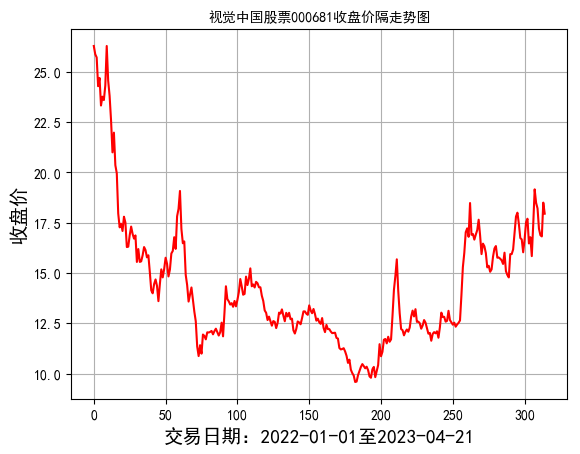

In [88]:
plt.figure()
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
 
plt.plot(list(range(len(Stock_close))), Stock_close, color='r')
plt.xlabel('交易日期：2022-01-01至'+end_, fontsize=14)
plt.ylabel('收盘价', fontsize=14)
plt.title('视觉中国股票000681收盘价隔走势图', fontsize=10)
plt.grid()
plt.show()

## 分割数据

In [51]:
Stock_XRHJ = pd.read_csv('SJZG000681.csv',index_col = 'trade_date',parse_dates=['trade_date'])
df = pd.DataFrame(Stock_XRHJ)
df=df.iloc[::-1]

#1.数据准备
df.index = pd.to_datetime(df.index)
sub    = df['2022-01-01':end_]['close']
train  = df['2022-01-01':'2022-12-31']['close']
val    = df['2023-01-01':'2023-02-28']['close']
test   = df['2023-03-01':end_]['close']
plt.figure(figsize=(20,10))
plt.plot(sub)
plt.xlabel('总数据 2022-01-01~'+end_, fontsize=10)
plt.ylabel('收盘价', fontsize=10)
plt.grid()
plt.show()
plt.plot(train)
plt.xlabel('训练数据 2022-01-01~2022-12-31', fontsize=10)
plt.ylabel('收盘价', fontsize=10)
plt.grid()
plt.show()
plt.plot(val)
plt.xlabel('验证数据 2023-01-01~2023-02-28', fontsize=10)
plt.ylabel('收盘价', fontsize=10)
plt.grid()
plt.show()
plt.plot(test)
plt.xlabel('测试数据 2023-03-01~'+end_, fontsize=10)
plt.ylabel('收盘价', fontsize=10)
plt.grid()
plt.show()

            Unnamed: 0    ts_code   open   high    low  close  pre_close  \
trade_date                                                                 
2022-01-04         318  000681.SZ  24.40  26.29  23.95  26.29      23.90   
2022-01-05         317  000681.SZ  25.50  27.60  25.38  25.88      26.29   
2022-01-06         316  000681.SZ  25.21  26.45  24.12  25.72      25.88   
2022-01-07         315  000681.SZ  26.07  27.28  24.10  24.29      25.72   
2022-01-10         314  000681.SZ  23.71  25.30  23.03  24.70      24.29   
...                ...        ...    ...    ...    ...    ...        ...   
2023-04-21           4  000681.SZ  18.89  19.22  17.80  17.95      18.50   
2023-04-24           3  000681.SZ  17.95  18.26  17.05  17.44      17.95   
2023-04-25           2  000681.SZ  18.12  18.45  16.79  17.62      17.44   
2023-04-26           1  000681.SZ  17.20  19.15  17.05  18.50      17.62   
2023-04-27           0  000681.SZ  18.00  18.00  16.65  16.65      18.50   

           

# 差分法分析，d的确定

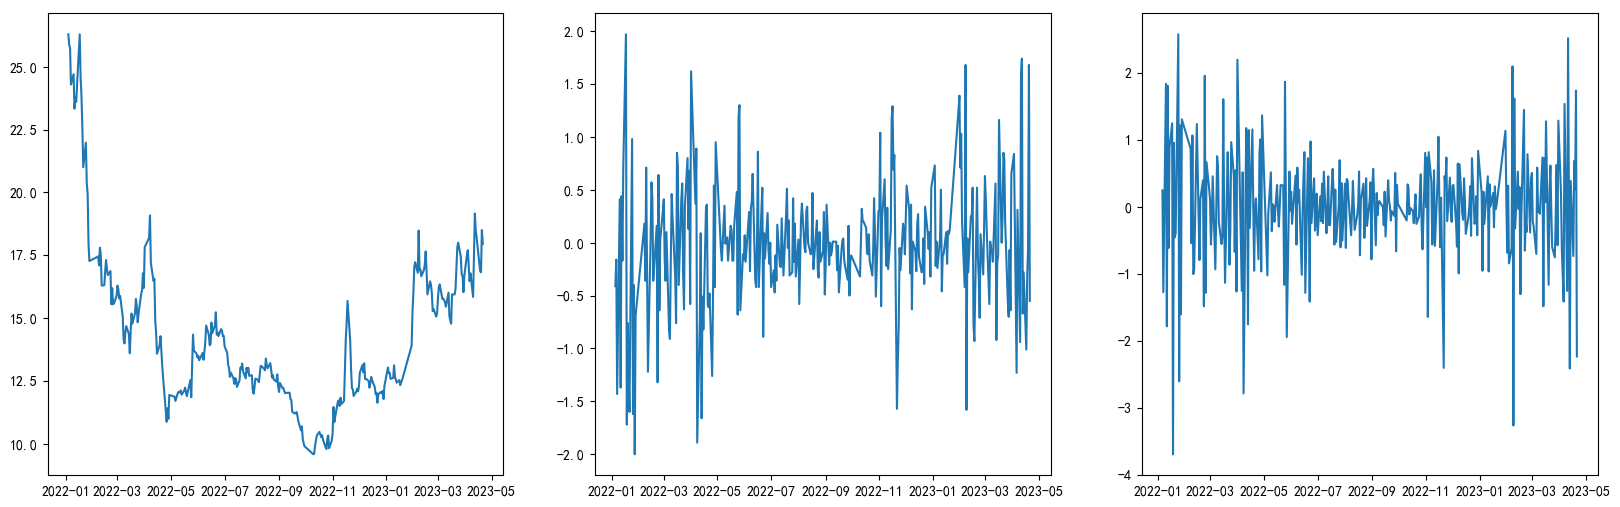

In [90]:
#2.差分法
df['Close_diff_1'] = df['close'].diff(1)#一阶差分
df['Close_diff_2'] = df['Close_diff_1'].diff(1)#二阶差分

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(131)
ax1.plot(df['close'])
ax2 = fig.add_subplot(132)
ax2.plot(df['Close_diff_1'])
ax3 = fig.add_subplot(133)
ax3.plot(df['Close_diff_2']) 
plt.show()

由此可见，数据本身就有着良好的稳定性。

# p,q的确定

## ACF和PACF

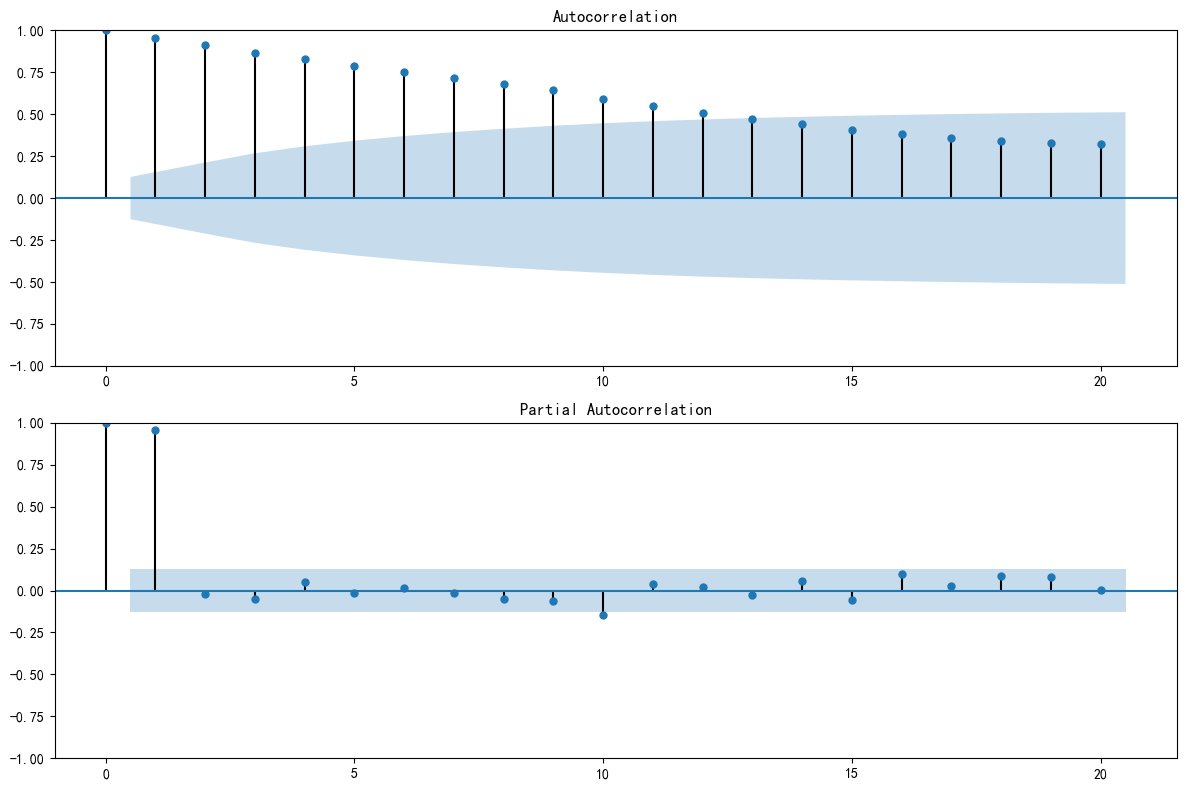

In [91]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()

由于ACF图像拖尾，PACF图像截尾，所以选择AR模型。
其中p的值是PACF图中最后一个超出二倍标准差的阶数，即AR(2)。

## BIC热力图

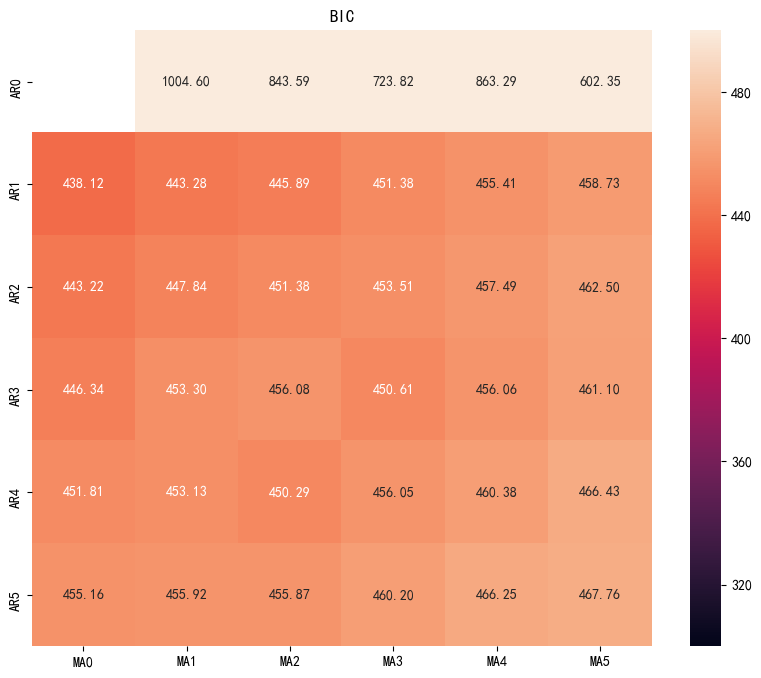

In [92]:
p_min = 0
d_min = 0
q_min = 0
p_max = 5
d_max = 0
q_max = 5
 
# Initialize a DataFrame to store the results,以BIC准则
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)]) 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    try:
        model = sm.tsa.ARIMA(train, order=(p, d, q))
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 vmin=300,
                 vmax=500
                 )
ax.set_title('BIC')
plt.show()

根据热力图得到BIC(1,0),表明我们应该选择AR(1)模型

## 模型定阶法

In [93]:
train_results = st.arma_order_select_ic(train, max_ar=8, max_ma=8, ic=['aic', 'bic'])
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 2)
BIC (1, 0)


指示应选择ARMA(4,2)或AR(1)模型

## 模型判优

在AR(1)、AR(2)和ARMA(4,2)模型上，对验证集做预测，根据预测结果，选择最终的模型。

参数解释：

MAE 平均绝对误差（Mean Absolute Error)：当预测值和真实值完美吻合时等于0，否则误差越大，该值越大。

MAPE 平均绝对百分比误差（Mean Absolute Percentage Error)：同上，大于100%时表示劣质模型。

R<sup>2</sup> 正确率，在0～1之间。

In [94]:
# AR(1)
print('AR(1)')
model = sm.tsa.ARIMA(sub, order=(1, 0, 0))#ARIMA(1,0,0)模型
results = model.fit()
predict_sunspots = results.predict(start=str('2023-01-03'),end=str('2023-02-28'),dynamic=False)
mae=mean_absolute_error(val,predict_sunspots)
print('MAE:',mae)
mse=mean_squared_error(val,predict_sunspots)
print('MSE:',mse)
r2=r2_score(val,predict_sunspots)
print('R2:',r2)

# AR(2)
print('AR(2)')
model = sm.tsa.ARIMA(sub, order=(2, 0, 0))#ARIMA(2,0,0)模型
results = model.fit()
predict_sunspots = results.predict(start=str('2023-01-03'),end=str('2023-02-28'),dynamic=False)
mae=mean_absolute_error(val,predict_sunspots)
print('MAE:',mae)
mse=mean_squared_error(val,predict_sunspots)
print('MSE:',mse)
r2=r2_score(val,predict_sunspots)
print('R2:',r2)

# ARMA(4,2)
print('ARMA(4,2)')
model = sm.tsa.ARIMA(sub, order=(4, 0, 2))#ARIMA(4,0,2)模型
results = model.fit()
predict_sunspots = results.predict(start=str('2023-01-03'),end=str('2023-02-28'),dynamic=False)
mae=mean_absolute_error(val,predict_sunspots)
print('MAE:',mae)
mse=mean_squared_error(val,predict_sunspots)
print('MSE:',mse)
r2=r2_score(val,predict_sunspots)
print('R2:',r2)

AR(1)
MAE: 0.4545082444015438
MSE: 0.40376636345220956
R2: 0.8956568444052755
AR(2)
MAE: 0.4558012674184517
MSE: 0.403449589747235
R2: 0.895738706519058
ARMA(4,2)
MAE: 0.4651769345183291
MSE: 0.42034344043651095
R2: 0.8913729201370683


对上方三组数据构建的模型综合考虑，AR(1)模型误差小、准确率高，因此选择<span class="burk">AR(1)</span>,即ARIMA(1,0,0)。

# 模型检验

## 残差序列的随机性检验

<Figure size 1200x800 with 0 Axes>

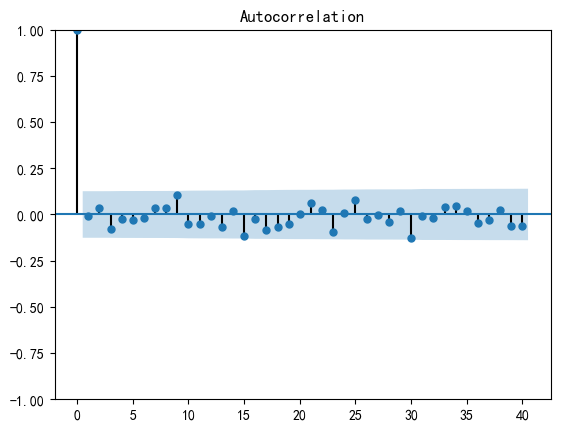

In [95]:
model = sm.tsa.ARIMA(train, order=(1, 0, 0))
results = model.fit()
resid = results.resid #赋值
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40)
plt.show()

残差独立性高

## D-W检验

In [96]:
print(sm.stats.durbin_watson(results.resid.values))

1.5046617349553364


不存在（一阶）自相关性

## 正态分布检验

NormaltestResult(statistic=312.2926644012646, pvalue=1.536418598961616e-68)


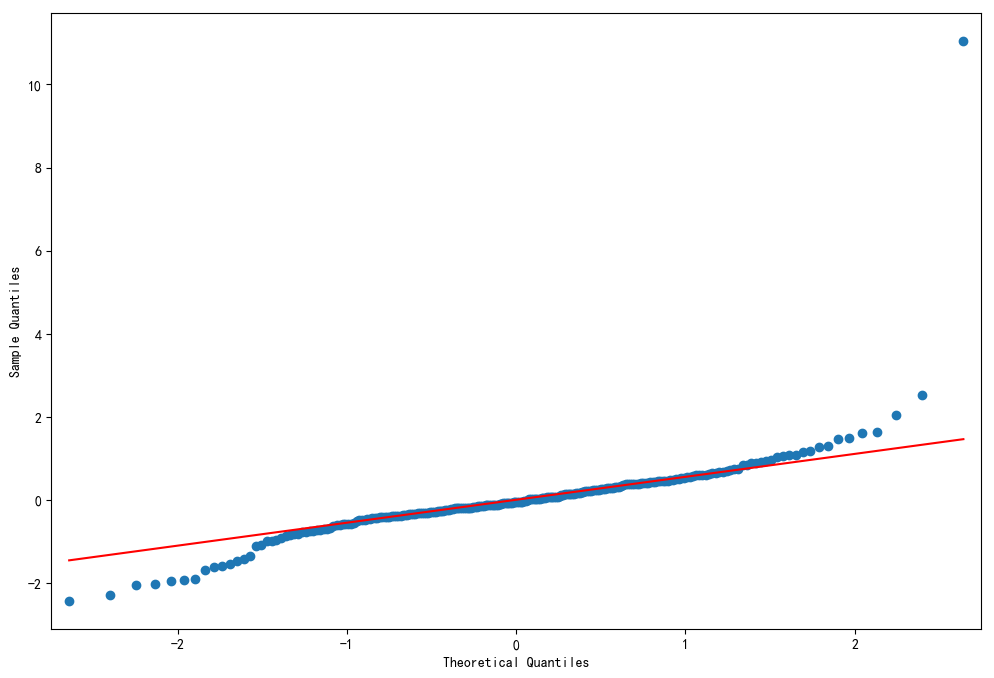

In [97]:
print(stats.normaltest(resid))
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

表明基本符合正态分布

# 模型预测

In [5]:
model = sm.tsa.ARIMA(sub, order=(1, 0, 0))#ARIMA(1,0,0)模型
results = model.fit()

D:\ANA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\ANA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\ANA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 预测2022年3月至今天的股票收盘价

MAE: 0.5964527747393249
MSE: 0.5951607917253962
R2: 0.47146270236184806


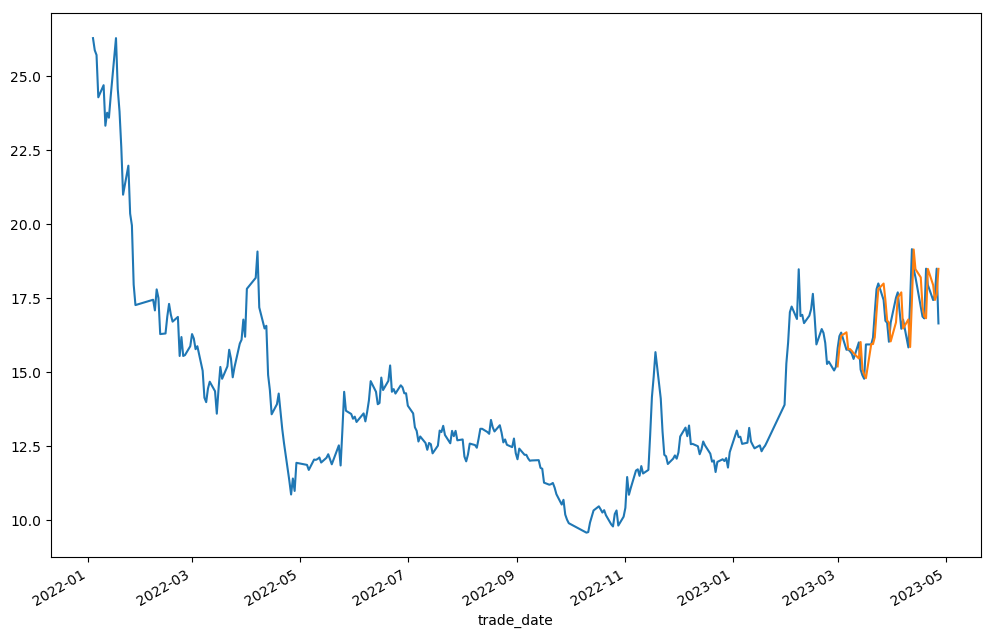

In [49]:
predict_sunspots = results.predict(start=str('2023-03-01'),end=end_,dynamic=False)
mae=mean_absolute_error(test,predict_sunspots)
print('MAE:',mae)
mse=mean_squared_error(test,predict_sunspots)
print('MSE:',mse)
r2=r2_score(test,predict_sunspots)
print('R2:',r2)
# print(predict_sunspots)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sub.plot(ax=ax)
predict_sunspots.plot(ax=ax)
plt.show()

## 预测今天往后10天股票收盘价

In [60]:
predict_sunspots = results.forecast(10)
print(predict_sunspots)
new_index = pd.date_range(start='2023-03-01', periods=len(predict_sunspots))
predict_sunspots.index = pd.date_range(start=end_, periods=len(end_), freq='D')
predict_sunspots.index = pd.to_datetime(predict_sunspots.index)
print(predict_sunspots)

319    16.657284
320    16.664515
321    16.671693
322    16.678820
323    16.685895
324    16.692918
325    16.699890
326    16.706812
327    16.713684
328    16.720505
Name: predicted_mean, dtype: float64
2023-04-27    16.657284
2023-04-28    16.664515
2023-04-29    16.671693
2023-04-30    16.678820
2023-05-01    16.685895
2023-05-02    16.692918
2023-05-03    16.699890
2023-05-04    16.706812
2023-05-05    16.713684
2023-05-06    16.720505
Freq: D, Name: predicted_mean, dtype: float64


D:\ANA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


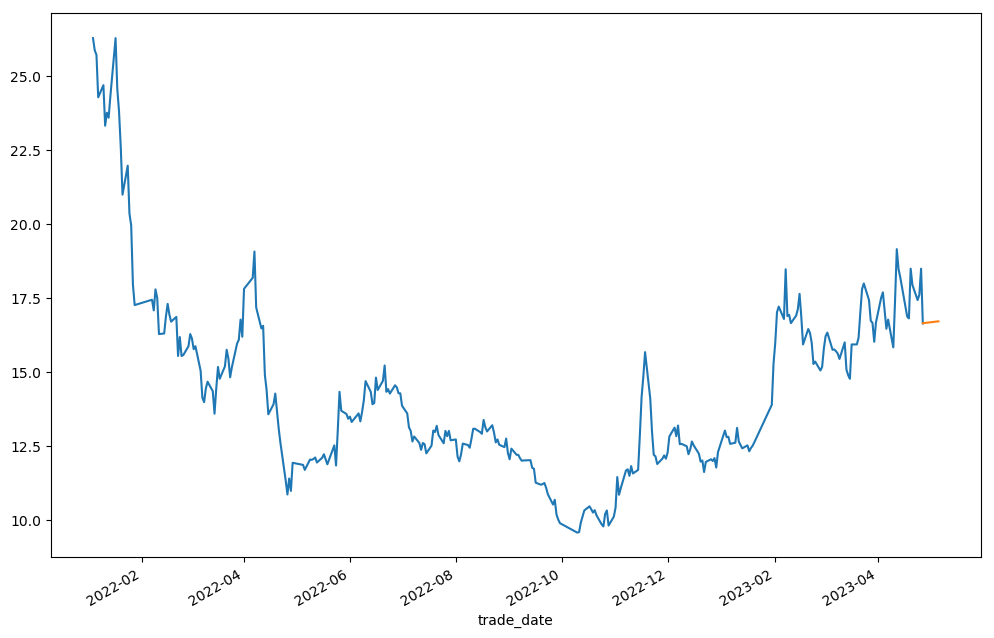

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sub.plot(ax=ax)
predict_sunspots.plot(ax=ax)
plt.show()